# Part 6: Currency Carry Strategy Analysis

## (a) 1. Setup and Data Loading

In [140]:
import pandas as pd
import numpy as np
from scipy import stats
pd.set_option('display.float_format', lambda x: f'{x:.10f}')

# Display options for pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

In [141]:
# Load the dataset
df = pd.read_csv('data/final/merged_all_data.csv', index_col=0)

# Drop unnecessary columns (fic: Fama French Industry Classification, currency: currency denomination of stock prices)
df = df.drop(columns={col for col in df.columns if col.startswith(('fic', 'currency'))})

print("Original DataFrame head:")
df.head()

Original DataFrame head:


,mportret_AUSTRALIA,mportretx_AUSTRALIA,mportret_SWITZERLAND,mportretx_SWITZERLAND,mportret_GERMANY,mportretx_GERMANY,mportret_FRANCE,mportretx_FRANCE,mportret_UNITED KINGDOM,mportretx_UNITED KINGDOM,mportret_JAPAN,mportretx_JAPAN,rm_US,rf_US,fx_USUK,fx_SZUS,fx_JPUS,fx_USAL,fx_USEU,euro_interbank,ch_interbank,us_interbank,australia_interbank,japan_interbank,uk_interbank
date,,,,,,,,,,,,,,,,,,,,,,,,,
2002-01-31,0.0273578567,0.0273132504,-0.0221262830,-0.0221460495,0.0122772449,0.0114909316,-0.0271048471,-0.0273056737,-0.0108660983,-0.0117199174,-0.0566551494,-0.0567096311,-0.0159660000,0.0014079107,1.4322000000,1.6709000000,132.6833000000,0.5170000000,0.8832000000,3.3387727273,1.6037251429,1.7400000000,4.2600000000,NaN,4.0467700000
2002-02-28,-0.0018319390,-0.0043578687,0.0116607107,0.0116456861,-0.0088072175,-0.0088160069,-0.0043939683,-0.0044474921,-0.0033406566,-0.0070717255,0.0422556653,0.0419976718,-0.0217000000,0.0014438782,1.4227000000,1.6970000000,133.6426000000,0.5128000000,0.8707000000,3.3571000000,1.5666706000,1.8200000000,4.3100000000,NaN,4.0526800000
2002-03-28,0.0051988097,-0.0019141565,0.0487594286,0.0455697800,0.0493281250,0.0484695259,0.0520810150,0.0519427042,0.0389300664,0.0336609706,0.0531190903,0.0482940937,0.0446980000,0.0014248364,1.4230000000,1.6743000000,131.0610000000,0.5256000000,0.8766000000,3.3908000000,1.6041637500,1.9100000000,4.4600000000,NaN,4.1305500000
2002-04-30,-0.0143019767,-0.0154244722,-0.0041086009,-0.0079612276,-0.0450305093,-0.0470927763,-0.0439877142,-0.0457546292,-0.0133618832,-0.0154110309,0.0205859787,0.0205737687,-0.0496000000,0.0014606291,1.4429000000,1.6542000000,130.7718000000,0.5352000000,0.8860000000,3.4069047619,1.4606466190,1.8700000000,4.5900000000,0.1000000000,4.1731900000
2002-05-31,-0.0002037861,-0.0017515748,0.0029628768,-0.0006387405,-0.0257027573,-0.0330684684,-0.0280161336,-0.0354866432,-0.0114824631,-0.0139372028,0.0359872785,0.0359202084,-0.0105100000,0.0014079107,1.4598000000,1.5889000000,126.3750000000,0.5498000000,0.9170000000,3.4671363636,1.1634939000,1.8200000000,4.8400000000,0.0800000000,4.1537000000


## 2. Data Preparation for Carry Strategy

### 2.1. Adjust FX Rates

In [142]:
# Convert FX rates to USD perspective (e.g., USD per CHF, USD per JPY)
df['fx_USSZ'] = 1 / df['fx_SZUS'] # USD per CHF
df['fx_USJP'] = 1 / df['fx_JPUS'] # USD per JPY

# Drop original columns for Swiss Franc and Japanese Yen FX rates against USD
df = df.drop(columns=['fx_SZUS', 'fx_JPUS'])

print("DataFrame head after FX rate adjustment:")
df.head()

DataFrame head after FX rate adjustment:


,mportret_AUSTRALIA,mportretx_AUSTRALIA,mportret_SWITZERLAND,mportretx_SWITZERLAND,mportret_GERMANY,mportretx_GERMANY,mportret_FRANCE,mportretx_FRANCE,mportret_UNITED KINGDOM,mportretx_UNITED KINGDOM,mportret_JAPAN,mportretx_JAPAN,rm_US,rf_US,fx_USUK,fx_USAL,fx_USEU,euro_interbank,ch_interbank,us_interbank,australia_interbank,japan_interbank,uk_interbank,fx_USSZ,fx_USJP
date,,,,,,,,,,,,,,,,,,,,,,,,,
2002-01-31,0.0273578567,0.0273132504,-0.0221262830,-0.0221460495,0.0122772449,0.0114909316,-0.0271048471,-0.0273056737,-0.0108660983,-0.0117199174,-0.0566551494,-0.0567096311,-0.0159660000,0.0014079107,1.4322000000,0.5170000000,0.8832000000,3.3387727273,1.6037251429,1.7400000000,4.2600000000,NaN,4.0467700000,0.5984798612,0.0075367435
2002-02-28,-0.0018319390,-0.0043578687,0.0116607107,0.0116456861,-0.0088072175,-0.0088160069,-0.0043939683,-0.0044474921,-0.0033406566,-0.0070717255,0.0422556653,0.0419976718,-0.0217000000,0.0014438782,1.4227000000,0.5128000000,0.8707000000,3.3571000000,1.5666706000,1.8200000000,4.3100000000,NaN,4.0526800000,0.5892751915,0.0074826440
2002-03-28,0.0051988097,-0.0019141565,0.0487594286,0.0455697800,0.0493281250,0.0484695259,0.0520810150,0.0519427042,0.0389300664,0.0336609706,0.0531190903,0.0482940937,0.0446980000,0.0014248364,1.4230000000,0.5256000000,0.8766000000,3.3908000000,1.6041637500,1.9100000000,4.4600000000,NaN,4.1305500000,0.5972645285,0.0076300349
2002-04-30,-0.0143019767,-0.0154244722,-0.0041086009,-0.0079612276,-0.0450305093,-0.0470927763,-0.0439877142,-0.0457546292,-0.0133618832,-0.0154110309,0.0205859787,0.0205737687,-0.0496000000,0.0014606291,1.4429000000,0.5352000000,0.8860000000,3.4069047619,1.4606466190,1.8700000000,4.5900000000,0.1000000000,4.1731900000,0.6045218232,0.0076469086
2002-05-31,-0.0002037861,-0.0017515748,0.0029628768,-0.0006387405,-0.0257027573,-0.0330684684,-0.0280161336,-0.0354866432,-0.0114824631,-0.0139372028,0.0359872785,0.0359202084,-0.0105100000,0.0014079107,1.4598000000,0.5498000000,0.9170000000,3.4671363636,1.1634939000,1.8200000000,4.8400000000,0.0800000000,4.1537000000,0.6293662282,0.0079129575


### 2.2. Calculate Monthly Interest Rates

In [143]:
# Define original interest rate column names
INTERBANK_RATE_COLS = {
    'AUD': 'australia_interbank', # Australia interbank rate
    'EUR': 'euro_interbank',      # Euro interbank rate
    'JPY': 'japan_interbank',     # Japan interbank rate
    'CHF': 'ch_interbank',        # Switzerland interbank rate
    'GBP': 'uk_interbank',        # UK interbank rate
    'USD': 'rf_US'                # US risk-free rate (assumed to be monthly)
}
CURRENCIES = ['USD', 'AUD', 'EUR', 'JPY', 'CHF', 'GBP']

# DataFrame to store monthly interest rates
df_rates_monthly = pd.DataFrame(index=df.index)

for currency in CURRENCIES:
    rate_col_original_name = INTERBANK_RATE_COLS[currency]
    target_col_name = f'rf_{currency}_monthly'

    if currency == 'USD':
        # rf_US is assumed to be already a monthly decimal return, no conversion needed
        df_rates_monthly[target_col_name] = pd.to_numeric(df[rate_col_original_name], errors='coerce')
    else:
        # Other interbank rates are assumed to be in annual percentage terms, convert to monthly decimal return
        df_rates_monthly[target_col_name] = pd.to_numeric(df[rate_col_original_name], errors='coerce') / (100 * 12)

print("Monthly interest rates (df_rates_monthly) head:")
df_rates_monthly.head()

Monthly interest rates (df_rates_monthly) head:


,rf_USD_monthly,rf_AUD_monthly,rf_EUR_monthly,rf_JPY_monthly,rf_CHF_monthly,rf_GBP_monthly
date,,,,,,
2002-01-31,0.0014079107,0.0035500000,0.0027823106,NaN,0.0013364376,0.0033723083
2002-02-28,0.0014438782,0.0035916667,0.0027975833,NaN,0.0013055588,0.0033772333
2002-03-28,0.0014248364,0.0037166667,0.0028256667,NaN,0.0013368031,0.0034421250
2002-04-30,0.0014606291,0.0038250000,0.0028390873,0.0000833333,0.0012172055,0.0034776583
2002-05-31,0.0014079107,0.0040333333,0.0028892803,0.0000666667,0.0009695782,0.0034614167


### 3. Construct Carry Strategy Portfolio

### 3.1. Calculate Carry Signals and Ranks

In [144]:
# Define currencies for carry trade (excluding USD as it's the base)
CURRENCIES_CARRY = ['AUD', 'EUR', 'JPY', 'CHF', 'GBP']

# Calculate carry signals (foreign interest rate - US interest rate)
carry_signals_df = pd.DataFrame(index=df_rates_monthly.index)
for currency in CURRENCIES_CARRY:
    carry_signals_df[currency] = df_rates_monthly[f'rf_{currency}_monthly'] - df_rates_monthly['rf_USD_monthly']

# Rank currencies based on carry signals (lower rank for lower carry, higher for higher carry)
ranks_df = carry_signals_df.rank(axis=1, method='first', ascending=True, na_option='keep')

print("Carry Signals (carry_signals_df) head:")
display(carry_signals_df.head())
print("\nRanks based on Carry (ranks_df) head:")
display(ranks_df.head())

Carry Signals (carry_signals_df) head:


,AUD,EUR,JPY,CHF,GBP
date,,,,,
2002-01-31,0.0021420893,0.0013743999,NaN,-0.0000714730,0.0019643977
2002-02-28,0.0021477885,0.0013537051,NaN,-0.0001383194,0.0019333551
2002-03-28,0.0022918303,0.0014008303,NaN,-0.0000880333,0.0020172886
2002-04-30,0.0023643709,0.0013784582,-0.0013772958,-0.0002434236,0.0020170292
2002-05-31,0.0026254227,0.0014813696,-0.0013412440,-0.0004383324,0.0020535060



Ranks based on Carry (ranks_df) head:


,AUD,EUR,JPY,CHF,GBP
date,,,,,
2002-01-31,4.0000000000,2.0000000000,NaN,1.0000000000,3.0000000000
2002-02-28,4.0000000000,2.0000000000,NaN,1.0000000000,3.0000000000
2002-03-28,4.0000000000,2.0000000000,NaN,1.0000000000,3.0000000000
2002-04-30,5.0000000000,3.0000000000,1.0000000000,2.0000000000,4.0000000000
2002-05-31,5.0000000000,3.0000000000,1.0000000000,2.0000000000,4.0000000000


### 3.2. Calculate Portfolio Weights

In [145]:
# Calculate portfolio weights based on ranks
weights_df = pd.DataFrame(index=ranks_df.index, columns=ranks_df.columns, dtype=float)

for date_index, rank_series_for_date in ranks_df.iterrows():
    valid_ranks = rank_series_for_date.dropna()  # Non-NaN ranks for the current date
    N_effective = len(valid_ranks)               # Number of effectively ranked currencies

    # Strategy requires at least one currency to long and one to short
    if N_effective < 2:
        weights_df.loc[date_index] = np.nan
        continue

    # Calculate normalization factor Z_effective
    Z_effective = 0.0
    if N_effective > 1:
        if N_effective % 2 == 1:  # Odd N_effective
            Z_effective = 8 / (N_effective**2 - 1)
        else:  # Even N_effective
            Z_effective = 8 / (N_effective**2)
    
    # Calculate weights: w_i,t = Z_effective * (rank_i,t - (N_t + 1)/2)
    calculated_weights_for_date = (valid_ranks - (N_effective + 1) / 2) * Z_effective
    weights_df.loc[date_index, valid_ranks.index] = calculated_weights_for_date

print("Portfolio Weights (weights_df) head:")
weights_df.head()

Portfolio Weights (weights_df) head:


,AUD,EUR,JPY,CHF,GBP
date,,,,,
2002-01-31,0.7500000000,-0.2500000000,NaN,-0.7500000000,0.2500000000
2002-02-28,0.7500000000,-0.2500000000,NaN,-0.7500000000,0.2500000000
2002-03-28,0.7500000000,-0.2500000000,NaN,-0.7500000000,0.2500000000
2002-04-30,0.6666666667,0.0000000000,-0.6666666667,-0.3333333333,0.3333333333
2002-05-31,0.6666666667,0.0000000000,-0.6666666667,-0.3333333333,0.3333333333


### 3.3. Calculate Currency Excess Returns(X_{t+1})

In [146]:
# Define FX rate column names in the main DataFrame 'df'
FX_COLS = {
    'AUD': 'fx_USAL', # USD per AUD
    'EUR': 'fx_USEU', # USD per EUR
    'JPY': 'fx_USJP', # USD per JPY
    'CHF': 'fx_USSZ', # USD per CHF
    'GBP': 'fx_USUK'  # USD per GBP
}

# Define monthly foreign risk-free rate column names from 'df_rates_monthly'
FOREIGN_RF_COLS_MONTHLY = {
    'AUD': 'rf_AUD_monthly',
    'EUR': 'rf_EUR_monthly',
    'JPY': 'rf_JPY_monthly',
    'CHF': 'rf_CHF_monthly',
    'GBP': 'rf_GBP_monthly'
}
DOMESTIC_RF_COL_MONTHLY = 'rf_USD_monthly' # Domestic (US) risk-free rate column name in 'df_rates_monthly'

# Calculate S_{t+1}/S_t (FX rate change)
S_df_for_X = pd.DataFrame(index=df.index)
for currency_code_map, fx_col_name in FX_COLS.items():
    S_df_for_X[currency_code_map] = df[fx_col_name]

S_t_plus_1_over_S_t = S_df_for_X[CURRENCIES_CARRY].shift(-1) / S_df_for_X[CURRENCIES_CARRY]
S_t_plus_1_over_S_t.columns = [f'S_ratio_{col}' for col in CURRENCIES_CARRY]

# DataFrame to store Currency Excess Returns X_{i, t+1} (calculated at t, for period t to t+1)
X_df = pd.DataFrame(index=df_rates_monthly.index)

for currency_code in CURRENCIES_CARRY:
    s_ratio = S_t_plus_1_over_S_t[f'S_ratio_{currency_code}']  # S_{t+1}/S_t at index t
    r_f_t = df_rates_monthly[FOREIGN_RF_COLS_MONTHLY[currency_code]]  # Foreign rate at time t
    r_d_t = df_rates_monthly[DOMESTIC_RF_COL_MONTHLY]                  # Domestic rate at time t

    # X_{i, t+1} = (S_{i, t+1}/S_i,t) * (1 + r_{f,i,t}) - (1 + r_{d,t})
    # Align s_ratio's index with X_df's index for calculation
    s_ratio_aligned = s_ratio.reindex(X_df.index)
    
    X_df[f'{currency_code}'] = s_ratio_aligned * (1 + r_f_t) - (1 + r_d_t)

print("Currency Excess Returns (X_df) head:")
#X_df.head()
X_df.tail()

Currency Excess Returns (X_df) head:


,AUD,EUR,JPY,CHF,GBP
date,,,,,
2024-08-30,0.0161529070,0.0062210036,0.0189920601,0.0091494297,0.0209643851
2024-09-30,-0.0105207818,-0.0198407718,-0.0499024967,-0.0193590575,-0.0131608325
2024-10-31,-0.0258429679,-0.0263286578,-0.0284065867,-0.0252731293,-0.0232704026
2024-11-29,-0.0296192187,-0.0150332800,-0.0038346727,-0.0148118259,-0.0067467932
2024-12-31,NaN,NaN,NaN,NaN,NaN


### 3.4. Calculate Carry Strategy Returns

In [147]:
# Clean and align weights and excess returns for final calculation
weights_df_cleaned = weights_df.dropna(how='all').copy()
X_df_cleaned = X_df.dropna(how='all').copy()


# Fill any remaining NaNs (e.g., from currencies not included in a specific month's ranking) with 0 for dot product
weights_df_cleaned.fillna(0, inplace=True)
X_df_cleaned.fillna(0, inplace=True) # Note: X_df's last row will be all NaN (due to S_{t+1}), then 0. This is handled by common_index.


# Ensure both DataFrames use a common index (excluding the last month where X_df is NaN)
common_index_final = weights_df_cleaned.index.intersection(X_df_cleaned.index)
weights_final_aligned = weights_df_cleaned.loc[common_index_final]
X_final_aligned = X_df_cleaned.loc[common_index_final]

# Calculate carry strategy returns: R_carry,t+1 = sum(w_i,t * X_i,t+1)
carry_returns_series = (X_final_aligned * weights_final_aligned).sum(axis=1)
df["carry_returns"] = carry_returns_series # Add to the main DataFrame

print("Carry Strategy Returns (in main df) head:")
print(df["carry_returns"].head())

Carry Strategy Returns (in main df) head:
date
2002-01-31    0.0091279103
2002-02-28    0.0088198930
2002-03-28    0.0073829884
2002-04-30   -0.0114906823
2002-05-31    0.0040555370
Name: carry_returns, dtype: float64


## Part b:  Performance Analysis

In [148]:
N_CURRENCIES_STAT = len(CURRENCIES_CARRY) #5

common_index = ranks_df.index.intersection(X_df.index) 
ranks_aligned = ranks_df.loc[common_index, CURRENCIES_CARRY]
X_aligned = X_df.loc[common_index, [f'{currency}' for currency in CURRENCIES_CARRY]]
X_aligned.columns = CURRENCIES_CARRY # Rename columns for easier masking (e.g., 'X_AUD' to 'AUD')

# Determine Long and Short Groups based on Ranks
num_in_leg = (N_CURRENCIES_STAT - 1) // 2 if N_CURRENCIES_STAT % 2 == 1 else N_CURRENCIES_STAT // 2 -1

long_mask = ranks_aligned > (N_CURRENCIES_STAT - num_in_leg)
short_mask = ranks_aligned <= num_in_leg

# Compute average return of long and short legs
# np.where applies the mask; np.nanmean calculates mean ignoring NaNs
long_returns = pd.Series(np.nanmean(np.where(long_mask, X_aligned, np.nan), axis=1), index=X_aligned.index)
short_returns = pd.Series(np.nanmean(np.where(short_mask, X_aligned, np.nan), axis=1), index=X_aligned.index)

# Get strategy returns from the main DataFrame, aligned with legs
strategy_returns_aligned = df["carry_returns"].loc[common_index]

# Combine into a DataFrame for statistical analysis
long_short_strategy_returns = pd.concat([
    long_returns,
    short_returns,
    strategy_returns_aligned
], axis=1, keys=['Long_Leg_Return', 'Short_Leg_Return', 'CARRY_Strategy_Return'])

# Align risk-free rate (rf_USD_monthly from df_rates_monthly) for Sharpe ratio calculation
rf = df_rates_monthly[DOMESTIC_RF_COL_MONTHLY]

long_short_strategy_returns

C:\Users\kaoru\AppData\Local\Temp\ipykernel_17416\2707670851.py:16: RuntimeWarning: Mean of empty slice
  long_returns = pd.Series(np.nanmean(np.where(long_mask, X_aligned, np.nan), axis=1), index=X_aligned.index)
C:\Users\kaoru\AppData\Local\Temp\ipykernel_17416\2707670851.py:17: RuntimeWarning: Mean of empty slice
  short_returns = pd.Series(np.nanmean(np.where(short_mask, X_aligned, np.nan), axis=1), index=X_aligned.index)


,Long_Leg_Return,Short_Leg_Return,CARRY_Strategy_Return
date,,,
2002-01-31,-0.0060105412,-0.0141450841,0.0091279103
2002-02-28,0.0271984385,0.0107930526,0.0088198930
2002-03-28,0.0206245548,0.0121167391,0.0073829884
2002-04-30,0.0217592607,0.0371607551,-0.0114906823
2002-05-31,0.0273547013,0.0275456700,0.0040555370
...,...,...,...
2024-08-30,0.0185586460,0.0140707449,0.0036493758
2024-09-30,-0.0118408072,-0.0346307771,0.0274405347
2024-10-31,-0.0245566852,-0.0268398580,0.0032341765


In [149]:

# Mean & Std of the return
mean_returns = long_short_strategy_returns.mean()
std_dev = long_short_strategy_returns.std()

#Sharpe ratio
excess_returns = long_short_strategy_returns.subtract(rf, axis=0)
sharpe_ratios = excess_returns.mean() / std_dev

results_b_df = pd.DataFrame({
    "Mean Return": mean_returns,
    "Std Dev": std_dev,
    "Sharpe Ratio": sharpe_ratios
})

# T-test for the CARRY strategy's average monthly return (use non-annualized monthly returns)
t_stat, p_value = stats.ttest_1samp(long_short_strategy_returns["CARRY_Strategy_Return"].dropna(), 0)
results_b_df.loc["CARRY_Strategy_Return", "T-statistic"] = t_stat
results_b_df.loc["CARRY_Strategy_Return", "P-value"] = p_value

print("\n--- Performance Statistics (Part b) ---")
results_b_df


--- Performance Statistics (Part b) ---


,Mean Return,Std Dev,Sharpe Ratio,T-statistic,P-value
Long_Leg_Return,0.0017516783,0.0216821429,0.0232467223,NaN,NaN
Short_Leg_Return,0.0005170537,0.0192415619,-0.0379691592,NaN,NaN
CARRY_Strategy_Return,0.0015825247,0.0220952389,0.0151564394,1.1877311587,0.2359679150


## Return Visualization

<Figure size 1200x600 with 0 Axes>

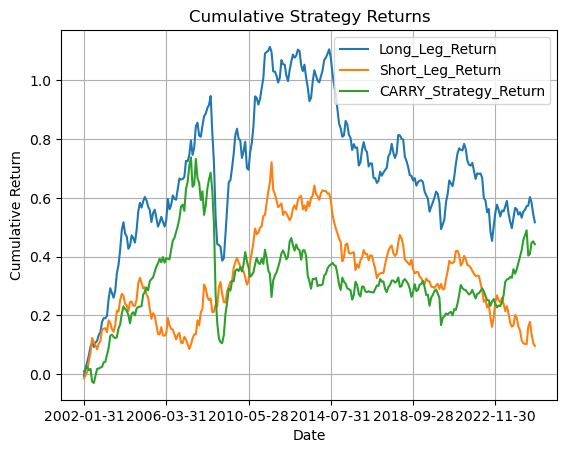

In [150]:
# Example: Plot cumulative returns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
cumulative_returns = (1 + long_short_strategy_returns).cumprod() -1
cumulative_returns.plot(title='Cumulative Strategy Returns')
plt.ylabel('Cumulative Return')
plt.xlabel('Date')
plt.grid(True)
plt.show()


## (c) Regression

In [151]:
import pandas as pd
import statsmodels.api as sm

# Load the data of DIV strategy and set 'date' as the index
DIV_return = pd.read_csv("data/final/returns_rp_hedged.csv", parse_dates=['date'])
DIV_return.set_index('date', inplace=True)

#Set carry strategy df
CARRY_return =  long_short_strategy_returns.drop(['Long_Leg_Return','Short_Leg_Return'], axis=1)
CARRY_return.index = pd.to_datetime(CARRY_return.index)

#Arrange the datetime
CARRY_return.index = CARRY_return.index + pd.offsets.MonthEnd(0)
DIV_return.index = DIV_return.index + pd.offsets.MonthEnd(0)

#Merge
returns_df = pd.concat([CARRY_return, DIV_return], axis=1, join='inner')
returns_df.columns = ['CARRY', 'DIV']

#Drop missing values to avoid bias in regression
returns_df = returns_df.dropna()

# Set up the regression model: regress MOM returns on DIV returns
X = sm.add_constant(returns_df['DIV'])  # add intercept (constant term α)
y = returns_df['CARRY']
model = sm.OLS(y, X).fit()

# 4. Display the regression summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  CARRY   R-squared:                       0.028
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     6.177
Date:                Fri, 06 Jun 2025   Prob (F-statistic):             0.0137
Time:                        18:41:42   Log-Likelihood:                 499.16
No. Observations:                 213   AIC:                            -994.3
Df Residuals:                     211   BIC:                            -987.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0007      0.002     -0.428      0.6